# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Fri Apr 21 15:32:06 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-21 15:32:09


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [124]:
run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number  = 3733
#run_number  = 3741

In [125]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [126]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3645/dst_3645.root.h5


In [127]:
full = load_dst(ifile)
print(len(full))
full.head()

94652


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,3,1.492202e+09,0,1,350.0,276.722809,1515.836656,531900.0,9.426875,11019.614258,...,654062.5,16,122.1625,122.1625,-21.497194,112.556617,114.591105,1.759514,8.018817,8.519045
1,4,1.492202e+09,0,1,325.0,241.455292,1415.866953,634600.0,4.767500,14362.279297,...,652437.5,18,17.8375,17.8375,100.035990,-137.599061,170.119666,-0.942171,8.840984,8.584587
2,5,1.492202e+09,0,1,350.0,242.239777,1455.815054,511650.0,9.163312,8109.848145,...,653862.5,14,142.2125,142.2125,107.072689,94.367245,142.722590,0.722408,7.784772,8.385585
3,6,1.492202e+09,0,1,300.0,313.980896,1775.244480,383825.0,10.691812,5046.355957,...,654862.5,13,271.0375,271.0375,45.982220,111.511962,120.620405,1.179687,8.719186,8.463334
4,8,1.492202e+09,0,1,300.0,274.860657,1514.563069,641400.0,5.188562,26482.410156,...,652562.5,23,11.1625,11.1625,-76.461523,76.361306,108.062082,2.356850,9.425307,9.171296


In [128]:
msc = full[full.S2e  >  400*units.pes * 11] # michel sorel cuts
msc = msc [msc.S1e   >   100*units.pes * 11] 
msc = msc [msc.S2w   > 3.5] # units of mus!!!
msc = msc [msc.S2w   <  25] # units of mus!!! 
msc = msc [msc.S1w   >  300*units.ns]
msc = msc [msc.S1w   < 1000*units.ns] 
msc = msc [msc.S1t   >  100*units.mus]
msc = msc [msc.S2t   <  700*units.mus]

msc = msc [msc.R     <  100*units.mm] # fidc

large_drift = full[full.DT > 530]



In [129]:
len(full)

94652

In [130]:
r = event_rate(full)

In [131]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 0.3288042229478673 evts/s


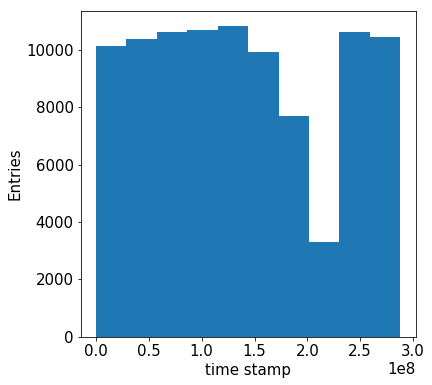

In [132]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

In [133]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

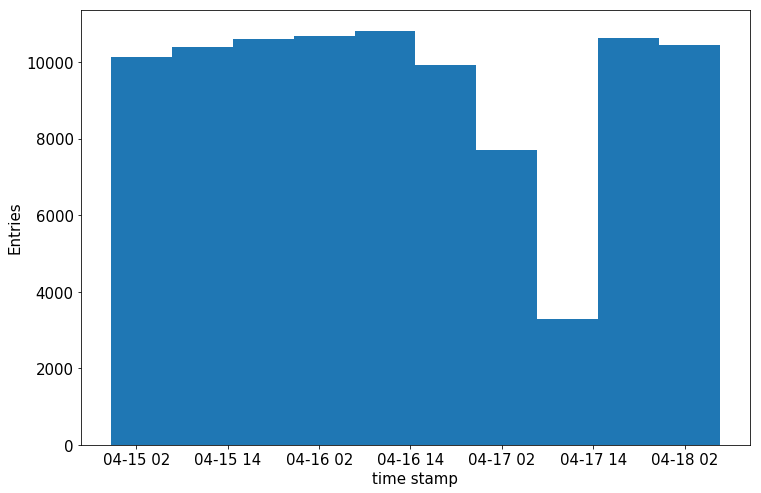

In [134]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [135]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [136]:
print(st)

2017-04-18 06:38:21


In [137]:
print(full.time.index[-1])

94651


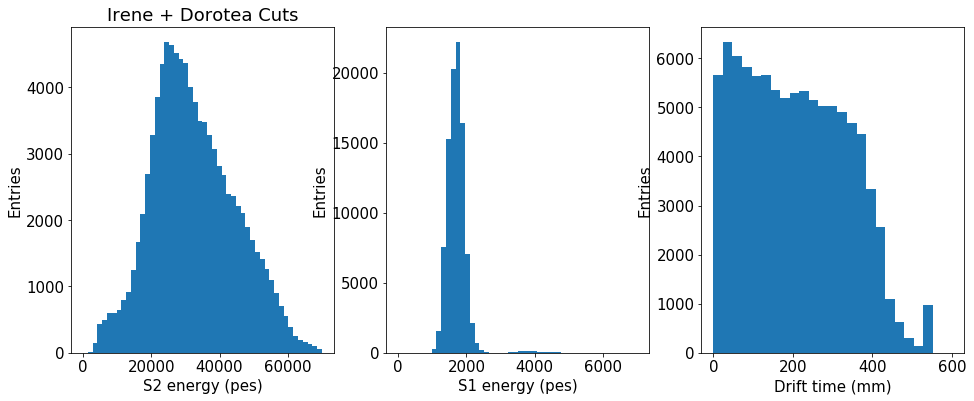

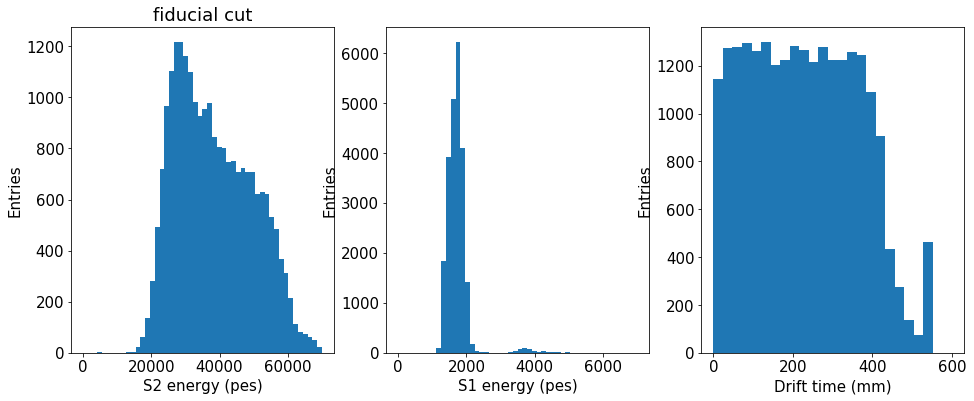

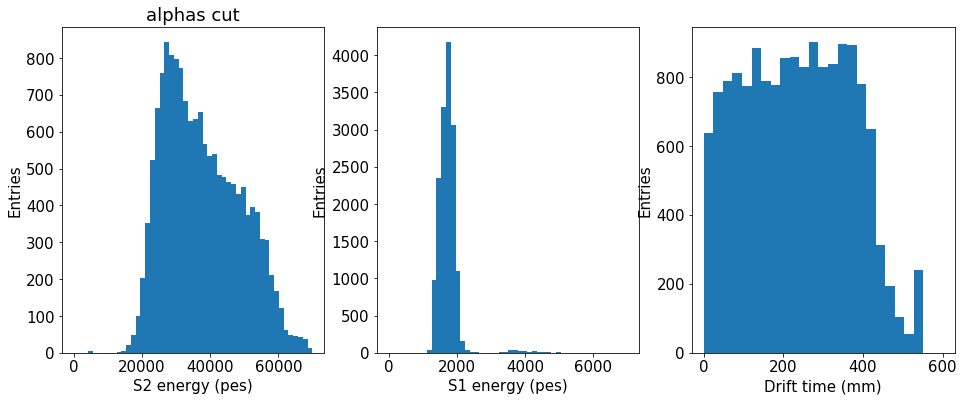

In [138]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fidc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fiducial cut')

ax = plt.subplot(1, 3, 2)
plt.hist(fidc.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(fidc.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(msc.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('alphas cut')

ax = plt.subplot(1, 3, 2)
plt.hist(msc.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(msc.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

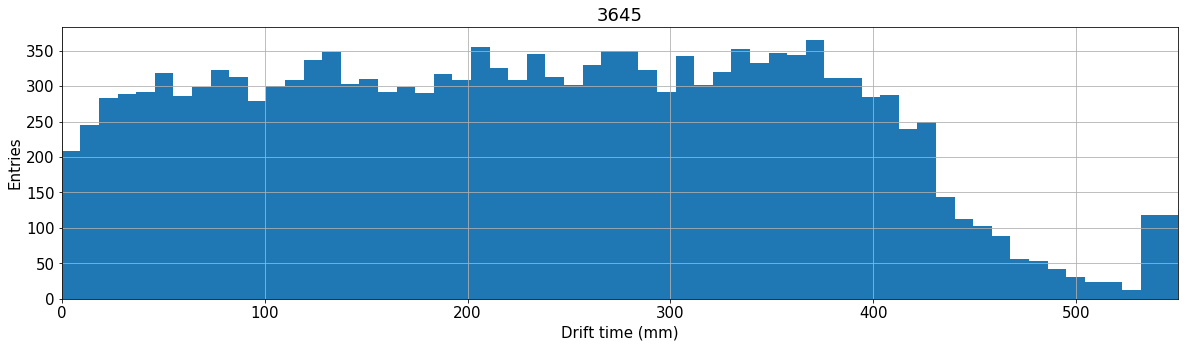

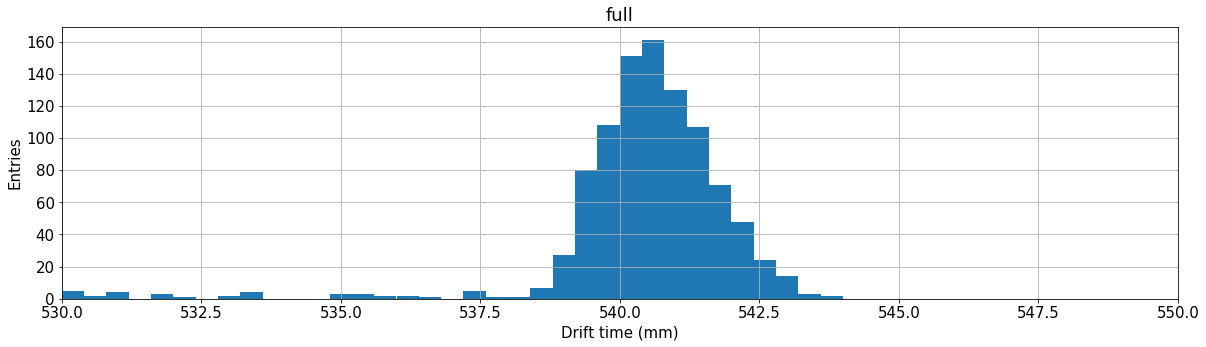

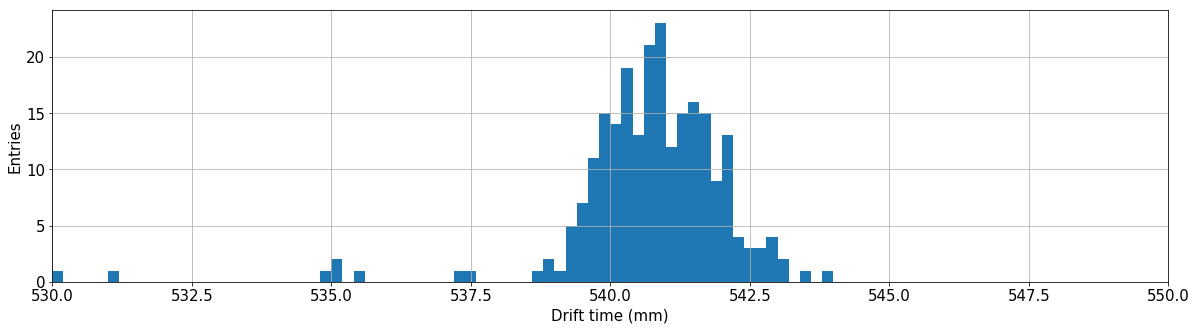

In [140]:
plt.figure(figsize=(20,5))
b = plt.hist(msc.Z, 60, (0, 550))
plt.xlim(0,550)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('{}'.format(run_number))


plt.figure(figsize=(20,5))
a = plt.hist(full[full.Z > 530].Z, 50, (530, 550))
plt.xlim(530,550)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('full')
  

plt.figure(figsize=(20,5))
b = plt.hist(msc[msc.Z > 530].Z, 100, (530, 550))
plt.xlim(530,550)
plt.grid(True)
labels("Drift time (mm)", "Entries")
#plt.title('alphas cut')



### Dependence with Z all alphas

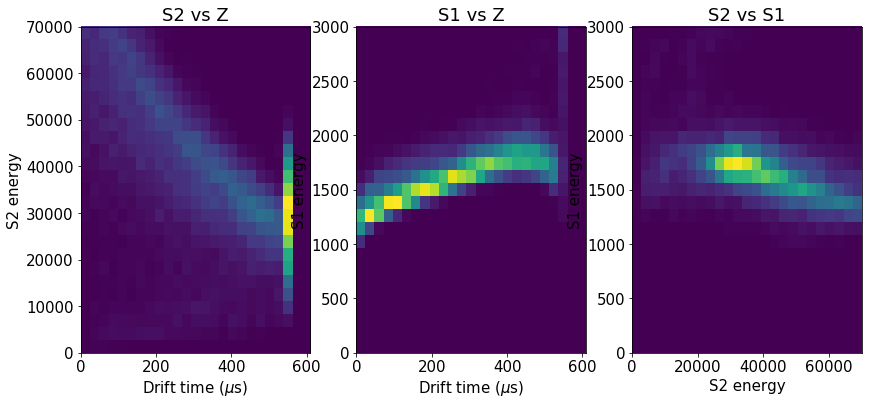

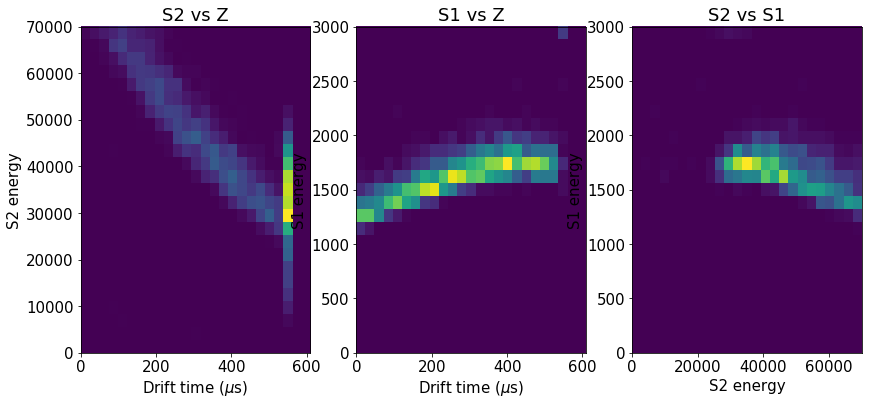

In [123]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(msc.Z, msc.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(msc.Z, msc.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(msc.S2e, msc.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [331]:
#core = blk[blk.R < 100]
core = full[full.R < 100]
print("Ratio wrt full:", len(core)/len(full))


core2 = full[full.Z > 300]
core2 = core2[core2.Z < 500]

#core= msc

Ratio wrt full: 0.25160673297628156


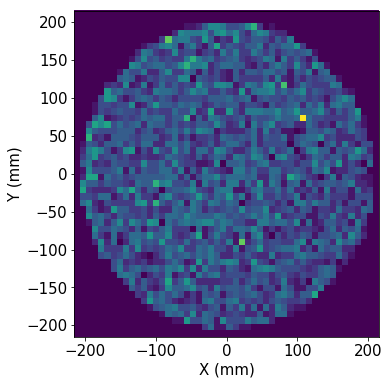

In [332]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(core2.X, core2.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")



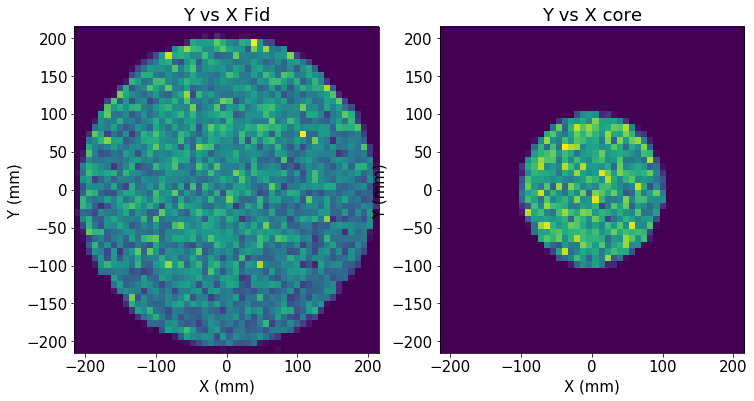

In [333]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

### Z correction for bulk 

#### S2

fit par[0] = 79732.52009211059 error = 1093.6958861435592
fit par[1] = -567.6872642048619 error = 17.956178123394928
degrees of freedom = 2
chi2 = 2.552255603159061


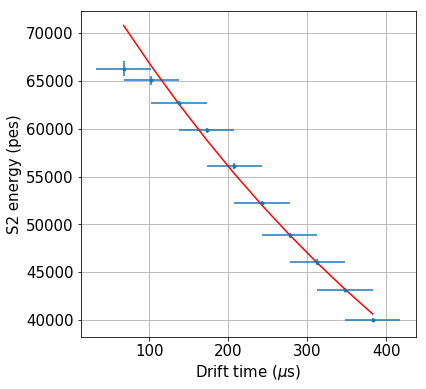

In [334]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [335]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.13397092578423872


#### Fit S2 in fiducial 

fit par[0] = 79732.52009211059 error = 1093.6958861435592
fit par[1] = -567.6872642048619 error = 17.956178123394928
degrees of freedom = 2
chi2 = 2.552255603159061


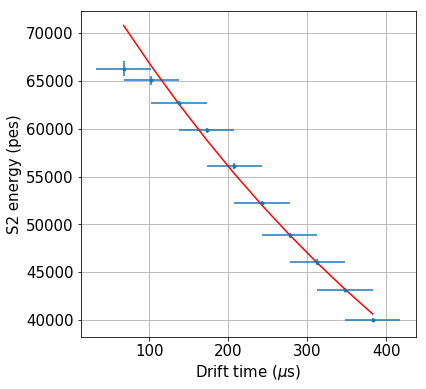

In [336]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [337]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-04-21 09:47:53 t1 = 2017-04-21 11:03:51


In [338]:
len(cz)

3502

using data set with length 3502
t0 = 2017-04-21 09:47:55 (index = 0) t1 = 2017-04-21 11:03:50 (index = 3502)
bin length = 700
 ---fit over events between 0 and 700
time0 = 2017-04-21 09:47:55 time1 = 2017-04-21 10:04:37
size of time leg = 700
fit par[0] = 91068.16748853268 error = 3037.799565485991
fit par[1] = -509.6769786607494 error = 34.45724993075877
degrees of freedom = 2
chi2 = 3.073669938683796
 ---fit over events between 700 and 1400
time0 = 2017-04-21 10:04:37 time1 = 2017-04-21 10:19:21
size of time leg = 700
fit par[0] = 85047.74794113133 error = 1069.3362816879155
fit par[1] = -521.9483127036882 error = 15.575792727024627
degrees of freedom = 2
chi2 = 1.6889662103752388
 ---fit over events between 1400 and 2100
time0 = 2017-04-21 10:19:21 time1 = 2017-04-21 10:34:58
size of time leg = 700
fit par[0] = 83354.88498691894 error = 356.06230017766
fit par[1] = -521.1547202784728 error = 5.023915527262006
degrees of freedom = 2
chi2 = 0.665464854437084
 ---fit over events betwee

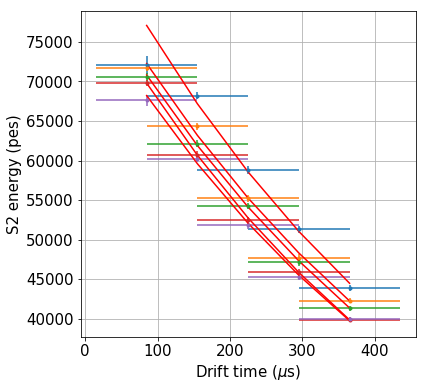

In [339]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(50,400), Erange=(1e+3, 80e3), nbins=5)

In [340]:
plot_options()

In [341]:
TSTAMP

['2017-04-21 10:04:37',
 '2017-04-21 10:19:21',
 '2017-04-21 10:34:58',
 '2017-04-21 10:49:55',
 '2017-04-21 11:03:48']

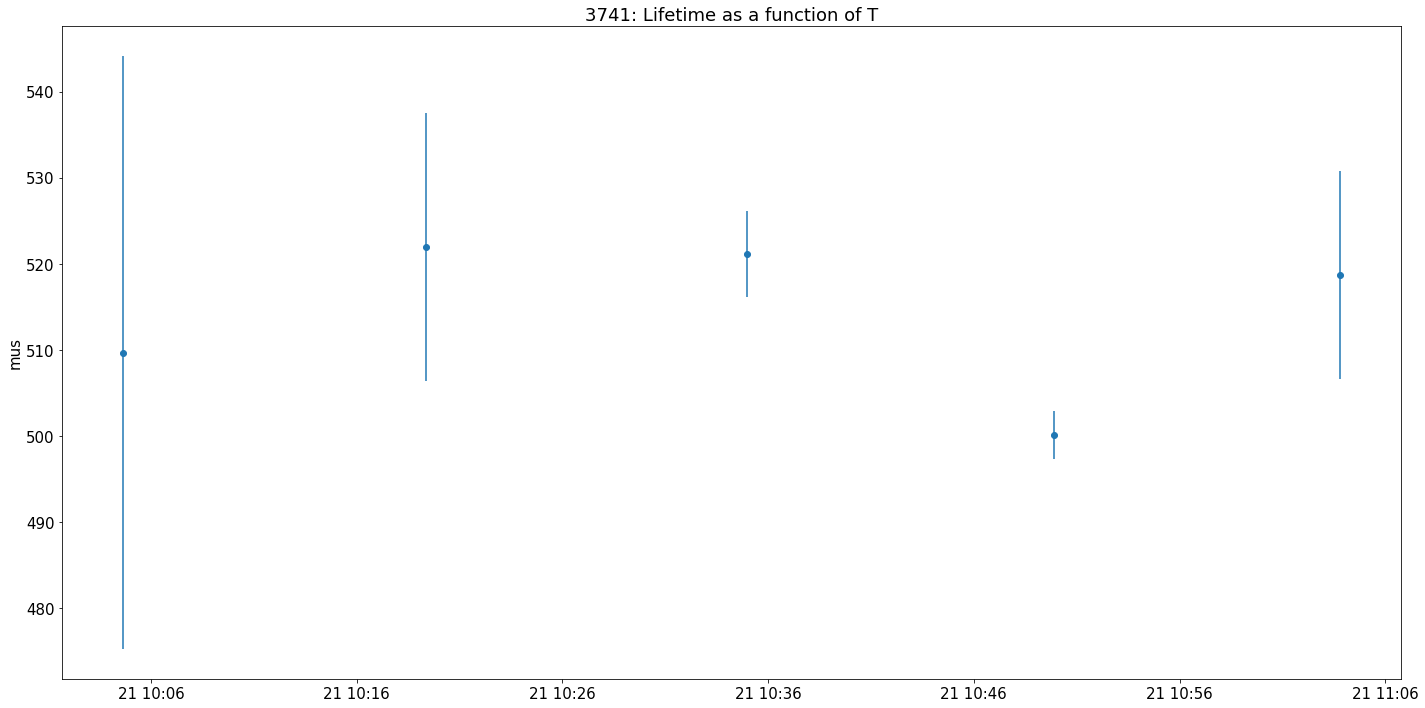

In [342]:
figsize=(24,12)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))

In [320]:
plog = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/')
pfiles = [plog + 'GAS_Log_2017-04-15.txt',
          plog + 'GAS_Log_2017-04-16.txt',
          plog + 'GAS_Log_2017-04-17.txt',
          plog + 'GAS_Log_2017-04-18.txt',
          plog + 'GAS_Log_2017-04-19.txt',
          plog + 'GAS_Log_2017-04-20.txt']
print(pfiles)

['/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-15.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-16.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-17.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-18.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-19.txt', '/Users/alej/Desktop/IC_DATA/LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-20.txt']


In [321]:
f0 = pd.read_csv(pfiles[0], skiprows=2, sep=None, engine='python')
f0

,Date,Hour,VG1,VG2,VG3,VG4,PG1,PG2,PG3,PG4,PG5,PG6,PGR2.2
0,15/04/2017,0:00:19,0.000020,0.000003,0.000001,1.937365,-0.133545,9.675583,6.942719,9.101624,6.696808,6.138596,7.672455
1,15/04/2017,0:00:50,0.000020,0.000003,0.000001,1.937365,-0.134079,9.639053,6.937912,9.081482,6.706039,6.171326,7.675812
2,15/04/2017,0:01:20,0.000020,0.000003,0.000001,1.937365,-0.130875,9.581650,6.950729,9.091553,6.659882,6.236786,7.672455
3,15/04/2017,0:01:51,0.000020,0.000003,0.000001,1.937365,-0.135681,9.670364,6.939514,9.059662,6.692612,6.274551,7.668259
4,15/04/2017,0:02:22,0.000020,0.000003,0.000001,1.937138,-0.136749,9.628616,6.936844,9.054626,6.687576,6.194824,7.669098
5,15/04/2017,0:02:52,0.000021,0.000003,0.000001,1.937365,-0.139420,9.748642,6.948593,9.055466,6.707718,6.141113,7.674133
6,15/04/2017,0:03:22,0.000020,0.000003,0.000001,1.937592,-0.131943,9.487717,6.949661,9.062180,6.677505,6.157898,7.669098
7,15/04/2017,0:03:53,0.000020,0.000003,0.000001,1.937365,-0.134613,9.769516,6.942719,9.048752,6.676666,6.215805,7.669098
8,15/04/2017,0:04:23,0.000020,0.000003,0.000001,1.937365,-0.132477,9.560776,6.955002,9.063019,6.668274,6.281265,7.673294
9,15/04/2017,0:04:54,0.000020,0.000003,0.000001,1.937365,-0.137283,9.837357,6.948059,9.064697,6.680023,6.354279,7.669098


In [322]:
#f = pd.read_csv(ppath, skiprows=2, sep=None, engine='python')

T  =[]
pg3=[]
pg6=[]
for f in pfiles: 
    f = pd.read_csv(f, skiprows=2, sep=None, engine='python')

    for d, t, g3, g6 in zip(f['Date'].values, f['Hour'].values, f['PG3'].values, f['PG6'].values):
        if len(t)==7: t = '0' + t
        T.append(datetime.datetime.strptime(d +' '+ t,'%d/%m/%Y %H:%M:%S'))
        pg3.append(g3)
        pg6.append(g6)
    print(len(T),len(pg3))


2843 2843
5688 5688
8532 8532
11637 11637
14483 14483
15923 15923


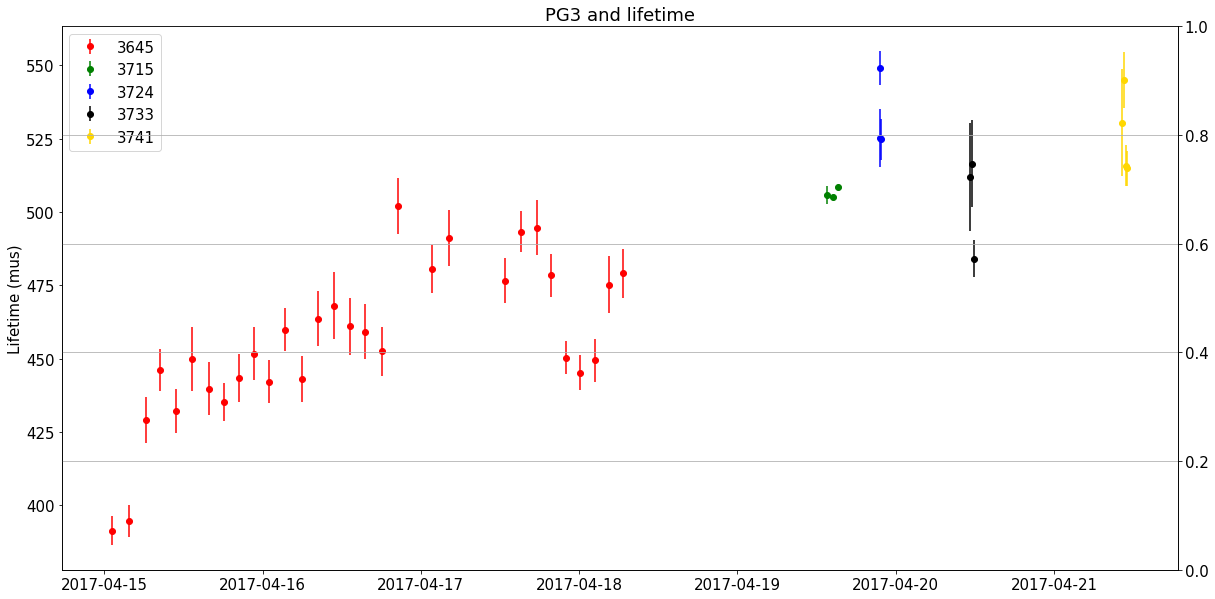

In [330]:
fig, ax1 = plt.subplots(figsize=(20, 10))
#ax1.errorbar(TIME[1:], -np.array(LAMBDA)[1:], yerr=ELAMBDA[1:], linestyle='none', fmt='o', c='r')
#r3741 = (TIME, -np.array(LAMBDA), ELAMBDA)
#r3741 = (TIME[1:], -np.array(LAMBDA)[1:], ELAMBDA[1:])
ax1.errorbar(r3645[0], r3645[1], yerr=r3645[2], linestyle='none', fmt='o', c='r', label='3645')
ax1.errorbar(r3715[0], r3715[1], yerr=r3715[2], linestyle='none', fmt='o', c='g', label='3715')
ax1.errorbar(r3724[0], r3724[1], yerr=r3724[2], linestyle='none', fmt='o', c='b', label='3724')
ax1.errorbar(r3733[0], r3733[1], yerr=r3733[2], linestyle='none', fmt='o', c='black', label='3733')
ax1.errorbar(r3741[0], r3741[1], yerr=r3741[2], linestyle='none', fmt='o', c='gold', label='3741')

plt.legend(loc=2)
ax1.set_ylabel('Lifetime (mus)')
ax2=ax1.twinx()
#ax2.plot(T, pg3,alpha=.2, label='asdf')
#ax2.set_ylabel('bar')
plt.title('PG3 and lifetime')
plt.grid(True)
plt.show()

In [141]:
print(r3645[2,0])

NameError: name 'r3645' is not defined